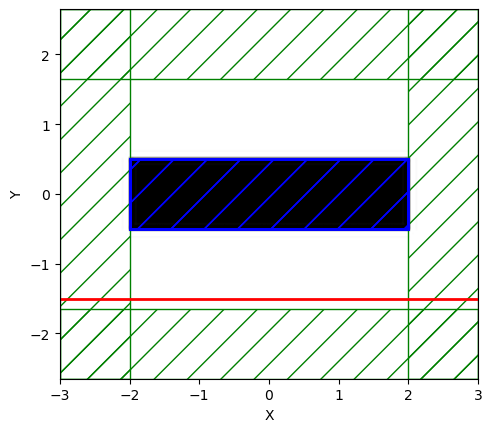

In [58]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

mp.verbosity(0)

Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1.0)

resolution = 20
pixel=1/resolution

design_region_width = 4
design_region_height = 1
pml_size = 1.0

Sx = 2 * pml_size + design_region_width
Sy = 2 * pml_size + design_region_height + 2 + 6*pixel
cell_size = mp.Vector3(Sx, Sy)

wavelengths = 2
frequencies = np.array([1/wavelengths])

nf = len(frequencies) # number of frequencies

design_region_resolution = int(resolution)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 2
width = 0.2
fwidth = width * fcen
source_center = [0, -(design_region_height/2+1), 0]
source_size = mp.Vector3(Sx, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]

Nx = 21
Ny = 6

#Nx = int(round(design_region_resolution * design_region_width)) + 1
#Ny = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

monitor_position, monitor_size = mp.Vector3(0,design_region_height/2+1), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,1]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    #decay_by=1e-2,
    #finite_difference_step=1e-3,
    #maximum_run_time=2000,
)

n = Nx * Ny  # number of parameters
x = np.ones((n,)) * 0.5
#x = np.loadtxt('/root/design_result/gd/lastdesign.txt')
opt.update_design([x])


opt.plot2D(True)


In [59]:
'''
x = np.loadtxt('/root/design_result/gd/lastdesign.txt')
dJ_du = np.loadtxt('/root/design_result/gd/dJ_du.txt')
adjoint_gradient = np.loadtxt('/root/design_result/gd/adjoint_gradient.txt')

x_image = x.reshape(Nx, Ny)
x_image=x_image.transpose()

plt.figure(figsize=(8, 6))
plt.imshow(x_image, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

print(x.shape, dJ_du.shape, adjoint_gradient.shape)
print(x_image.shape)
'''
print(Nx,Ny)

21 6


In [60]:
#x = np.loadtxt('/root/design_result/gd/lastdesign.txt')

#n = Nx * Ny  # number of parameters
#x = np.ones((n,)) * 0.5
#opt.update_design([x])

fdg_list=[]
eps_diff=0.001

f0, dJ_du = opt([x])
for i in range(x.size):
    print(i)
    copy_x=x.copy()
    copy_x[i] = copy_x[i]+eps_diff
    #print(copy_x)
    f0_new, dJ_du_new = opt([copy_x])
    f0_diff = f0_new - f0
    fdg = f0_diff / eps_diff
    #fdg_list.append(np.real(fdg))
    fdg_list.append(fdg)

np.savetxt("/root/design_result/gd/fdg_list.txt", fdg_list)


Starting forward run...
Starting adjoint run...
Calculating gradient...
0
Starting forward run...
Starting adjoint run...
Calculating gradient...
1
Starting forward run...
Starting adjoint run...
Calculating gradient...
2
Starting forward run...
Starting adjoint run...
Calculating gradient...
3
Starting forward run...
Starting adjoint run...
Calculating gradient...
4
Starting forward run...
Starting adjoint run...
Calculating gradient...
5
Starting forward run...
Starting adjoint run...
Calculating gradient...
6
Starting forward run...
Starting adjoint run...
Calculating gradient...
7
Starting forward run...
Starting adjoint run...
Calculating gradient...
8
Starting forward run...
Starting adjoint run...
Calculating gradient...
9
Starting forward run...
Starting adjoint run...
Calculating gradient...
10
Starting forward run...
Starting adjoint run...
Calculating gradient...
11
Starting forward run...
Starting adjoint run...
Calculating gradient...
12
Starting forward run...
Starting ad

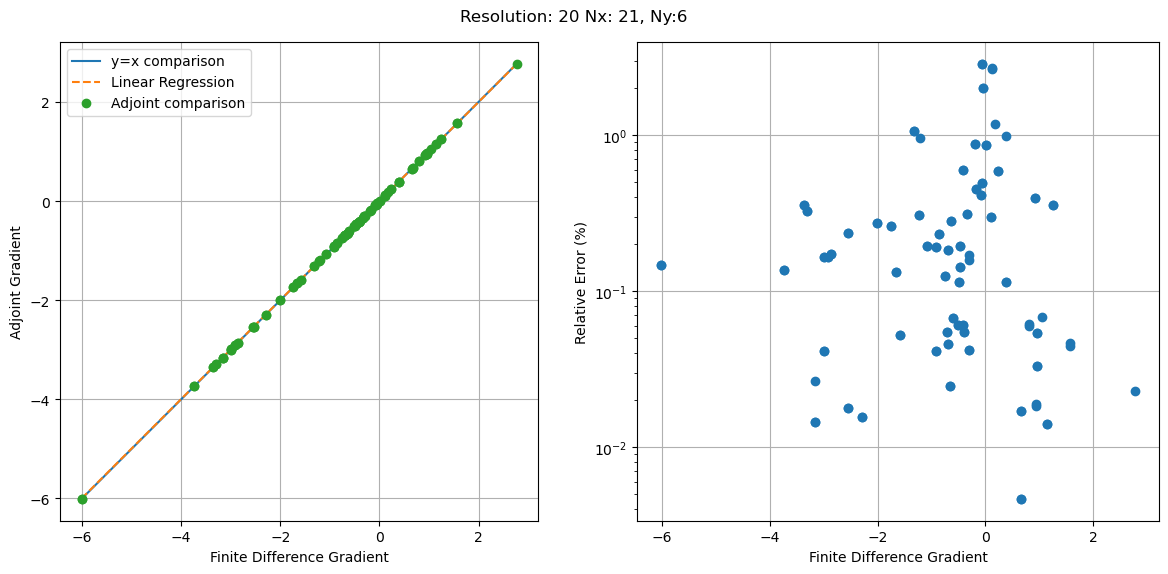

In [61]:
#MY FD와 ADG 비교
fdg_list = np.loadtxt('/root/design_result/gd/fdg_list.txt')
fd_gradient=np.array(fdg_list)
#print(x)
opt.update_design([x])
#(f, dJ_du)=opt.get_fdf_funcs()
#adjoint_gradient=dJ_du(x)
adjoint_gradient=dJ_du

(m, b) = np.polyfit(fd_gradient, adjoint_gradient, 1)
min_g = np.min(fd_gradient)
max_g = np.max(fd_gradient)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Linear Regression")
plt.plot(fd_gradient, adjoint_gradient, "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(fd_gradient) - np.squeeze(adjoint_gradient))
    / np.abs(np.squeeze(fd_gradient))
    * 100
)
plt.semilogy(fd_gradient, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Nx: {}, Ny:{}".format(resolution, Nx, Ny))
plt.show()

In [62]:
db = 1e-3 #finite difference step size
choose = Nx * Ny
fd_gradient, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)
print(idx) #design region의 pixel번호 
print(fd_gradient) #idx번째 pixel fd_gradient 값
np.savetxt("/root/design_result/gd/fd_gradient.txt", fd_gradient)

range(0, 126)
[[-2.543452889156139], [-2.991366233386472], [-0.8531085671572569], [-0.49998960871677767], [-2.87304301841651], [-3.357372649137602], [-0.40069449352042597], [-0.7144700828298767], [-0.17233402895344696], [0.3901230302316705], [-0.516266972335977], [-0.42372511156774095], [-1.2603702800371153], [-1.6076867207894807], [-0.9153381356656887], [0.007740627091745722], [-2.545993427159665], [-3.182014338331207], [-0.7219719511311062], [-0.6929034792868549], [-0.6553412689465077], [-0.3077587791175951], [-2.2965337504032846], [-3.0106136325129818], [-3.763941826727013], [-0.6804148274555111], [0.6542380211262966], [-0.76223466209413], [-0.08454661886503345], [-0.062062115803840356], [-6.056748508160403], [-1.80993225074344], [0.9418935884806245], [-0.9567573254476436], [1.1753992267919955], [0.8713334386714067], [-0.47149018065928416], [-0.09523680402390156], [0.6536158227441469], [-0.08900140177825477], [1.1111383836381883], [0.07279856981945443], [0.18042039564925005], [-1.71

Starting forward run...
Starting adjoint run...
Calculating gradient...


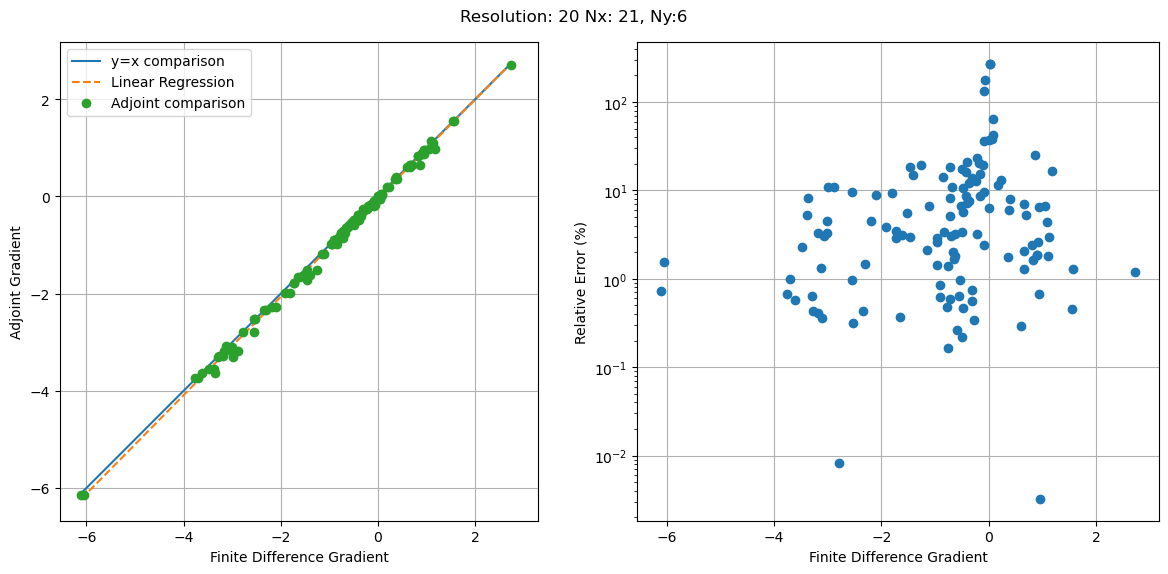

In [63]:
#MEEP FD와 ADG 비교
fd_gradient = np.loadtxt('/root/design_result/gd/fd_gradient.txt')
#print(x)
(f, dJ_du)=opt.get_fdf_funcs()
adjoint_gradient=dJ_du(x)

(m, b) = np.polyfit(np.squeeze(fd_gradient), adjoint_gradient[idx], 1)
min_g = np.min(fd_gradient)
max_g = np.max(fd_gradient)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Linear Regression")
plt.plot(fd_gradient, adjoint_gradient[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(fd_gradient) - np.squeeze(adjoint_gradient[idx]))
    / np.abs(np.squeeze(fd_gradient))
    * 100
)
plt.semilogy(fd_gradient, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Nx: {}, Ny:{}".format(resolution, Nx, Ny))
plt.show()

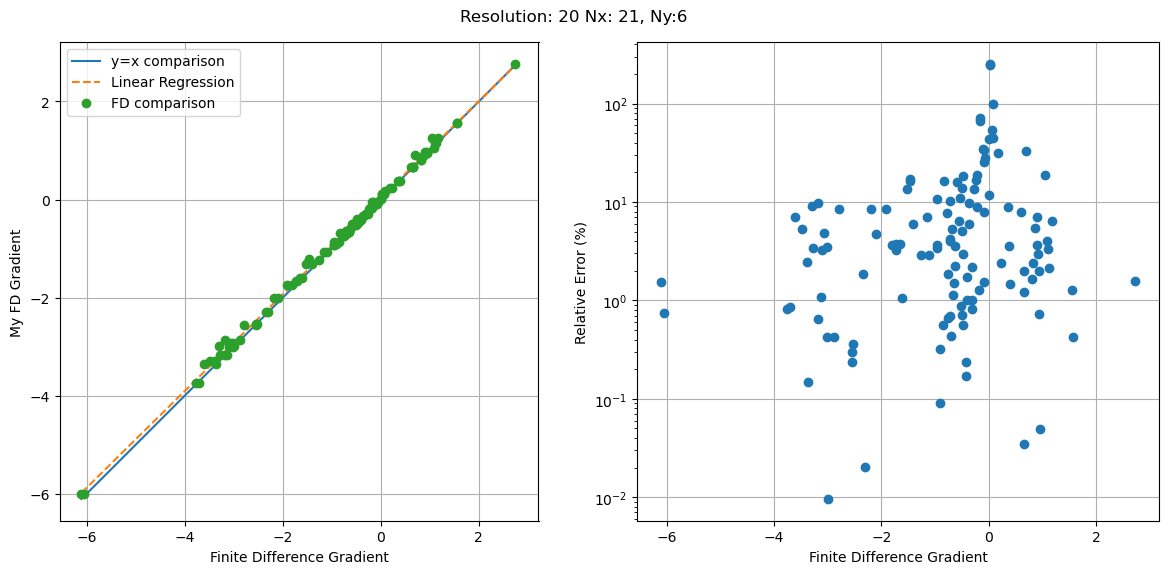

In [64]:
#MY FD와 MEEP FD비교
fdg_list = np.loadtxt('/root/design_result/gd/fdg_list.txt')
my_fd_gradient=np.array(fdg_list)

fd_gradient = np.loadtxt('/root/design_result/gd/fd_gradient.txt')


(m, b) = np.polyfit(np.squeeze(fd_gradient), my_fd_gradient, 1)
min_g = np.min(fd_gradient)
max_g = np.max(fd_gradient)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Linear Regression")
plt.plot(fd_gradient, my_fd_gradient, "o", label="FD comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("My FD Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(fd_gradient) - np.squeeze(my_fd_gradient))
    / np.abs(np.squeeze(fd_gradient))
    * 100
)
plt.semilogy(fd_gradient, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Nx: {}, Ny:{}".format(resolution, Nx, Ny))
plt.show()